(40, 40, 2)
stepnum	 Hsize	 F
50	 1.9310073754280492	 -10.504798664315862


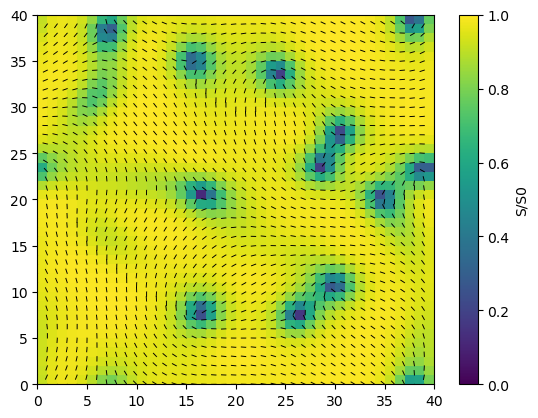

100	 1.2285358651342628	 -4.24888847194304


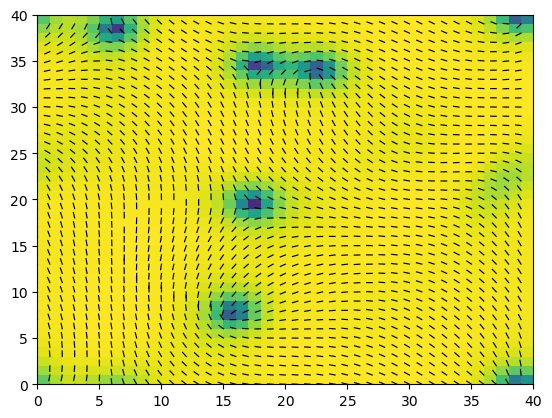

150	 0.8367117912141762	 -2.0336971332022533


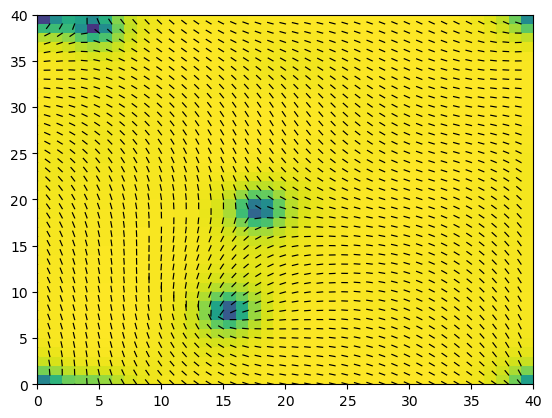

200	 0.571167228669449	 -1.0456257645708285


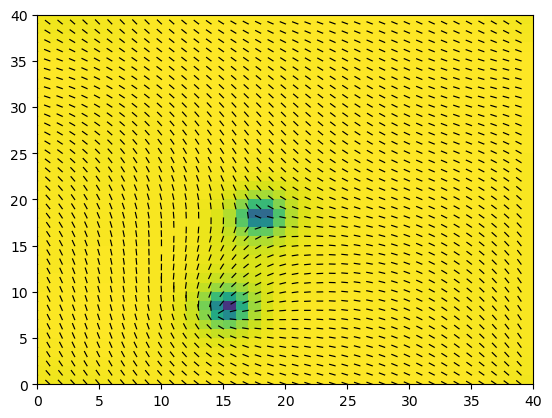

250	 0.407056741146335	 -0.8310362042297925


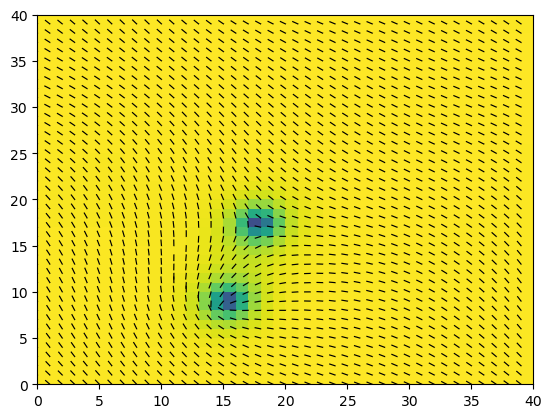

300	 0.43682760915663266	 -0.8383700131077136


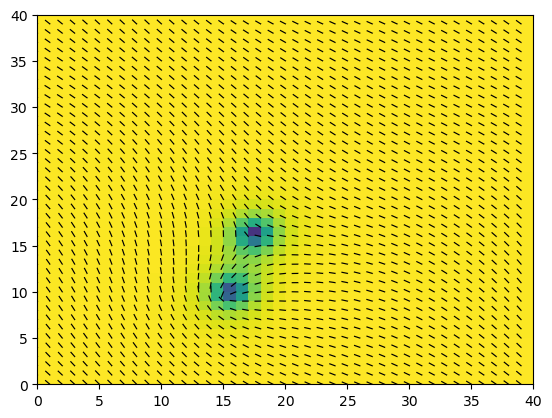

350	 1.2123724696414846	 -2.312446670704969


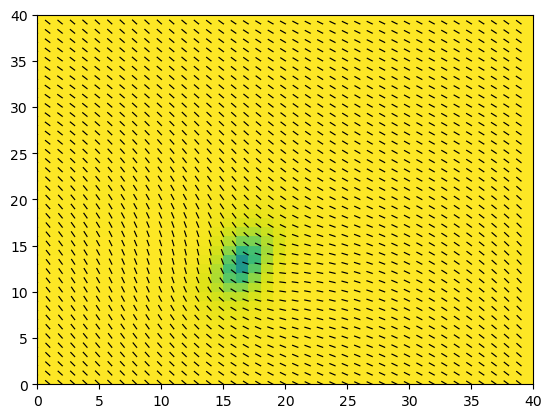

400	 0.353994144012352	 -0.15004065582513615


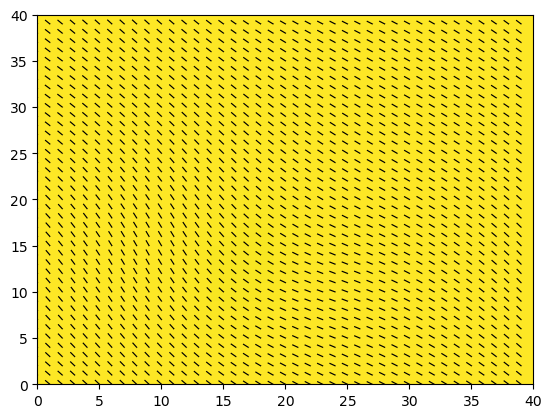

450	 0.22955180755900523	 -0.06138761625648787


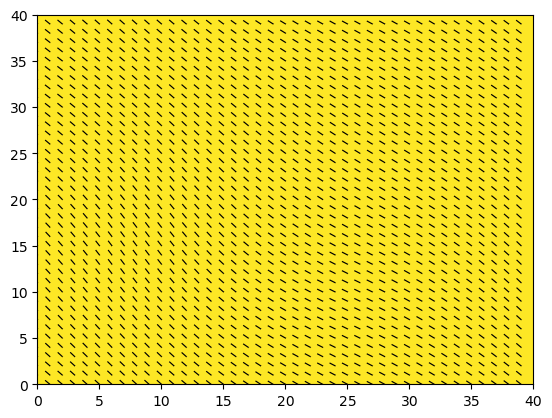

500	 0.16492240156947888	 -0.03159003320058584


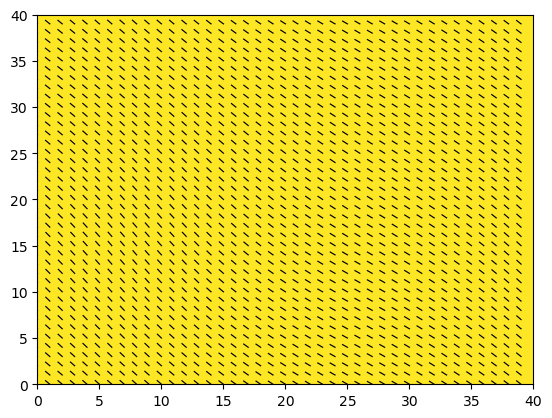

550	 0.12286372635155753	 -0.017554243024175183


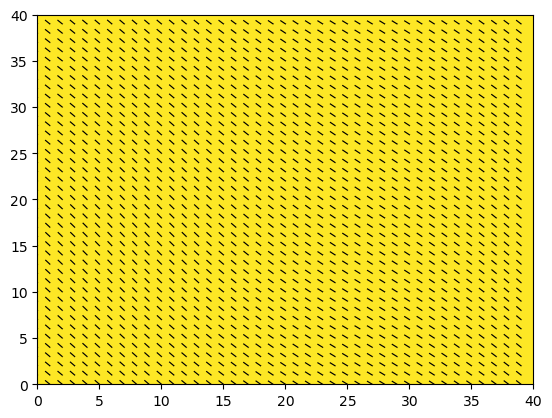

600	 0.09322251014909314	 -0.010124196797621538


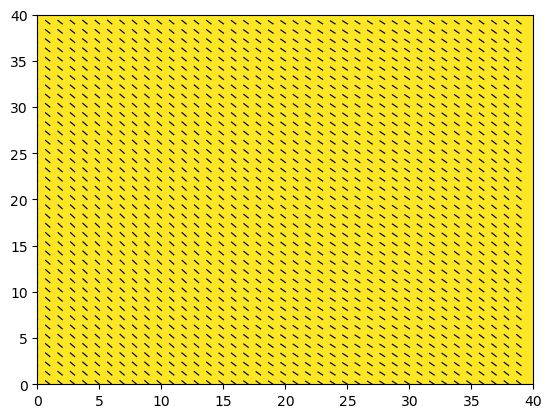

650	 0.07151193664672617	 -0.005966542610877429


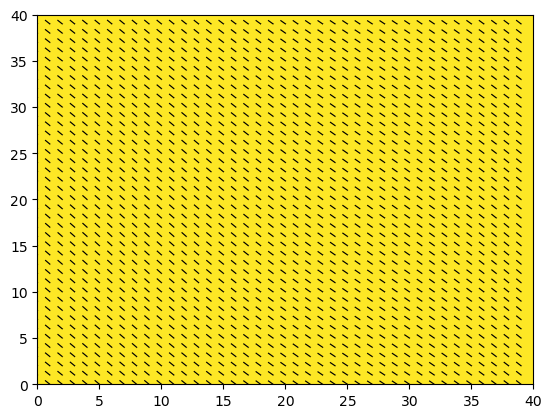

700	 0.055236765090691774	 -0.003563530975637362


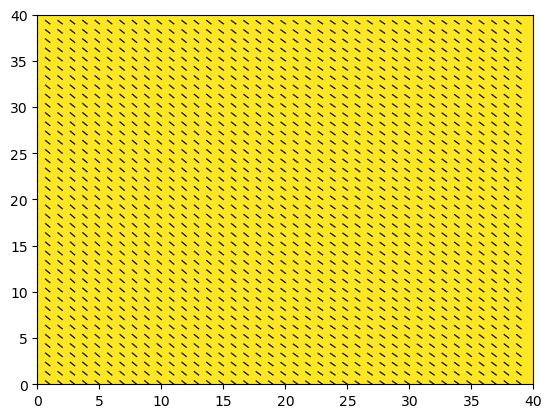

750	 0.04285118229714001	 -0.0021461168086577406


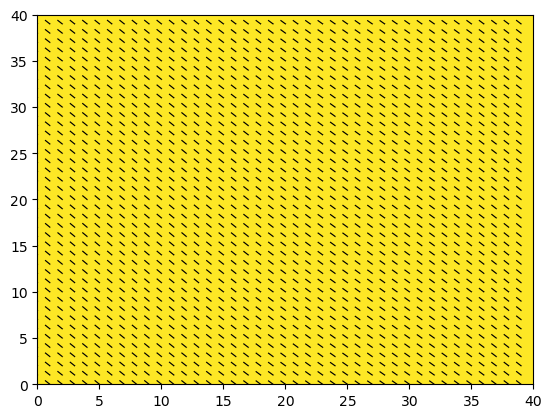

800	 0.0333330424632289	 -0.0012991872588945352


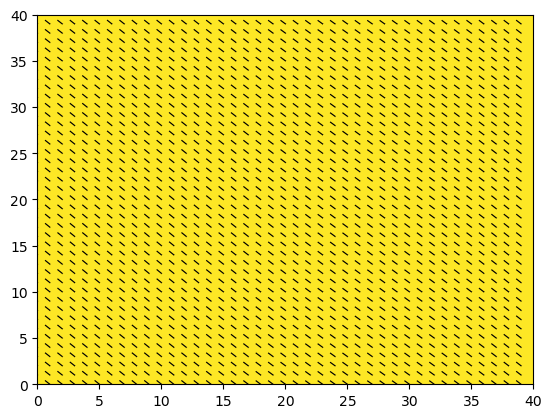

850	 0.025972674025290635	 -0.0007889995356877367


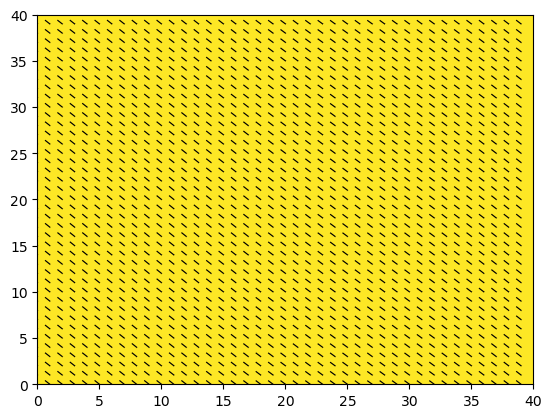

900	 0.020258513647203512	 -0.0004801023397445281


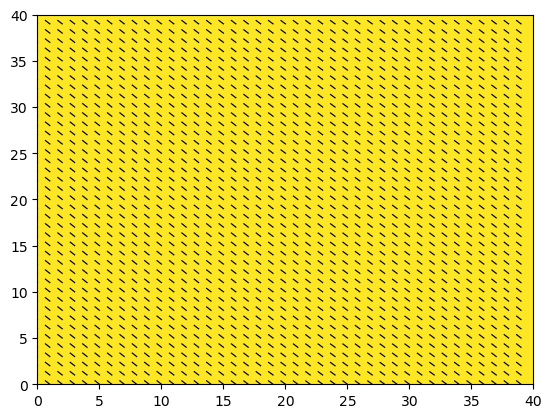

950	 0.015811531071087154	 -0.0002924911711077025


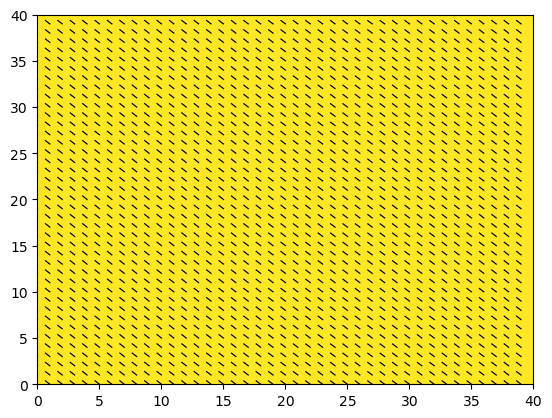

1000	 0.012345500688625857	 -0.00017832433927072279


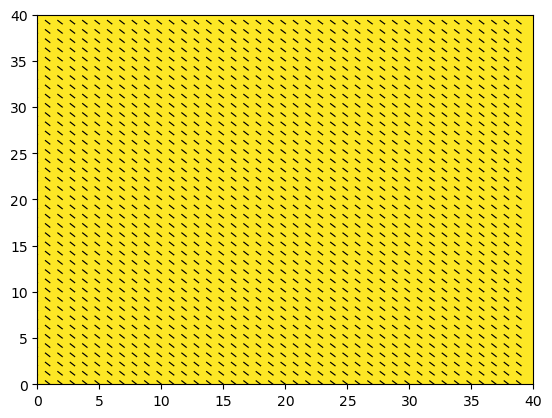

Success: reached stopping condition Hsize = 0.009980965681241401 <= 0.01
Done


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib import cm

# number of grad spacings in x
Lx = 40

# number of grad spacings in y
Ly = 40

# phase free energy density constants
A = -1
C = 1.5
S0 = np.sqrt(-A/(2.*C))

# elastic constant
L = 1

# constant coefficient for gradient descent
Gamma = 0.2

# stopping condition
Hsize_stop = 0.01#10e-5

# monitor progress every printstep timesteps
printstep = 50

# monitor progress graphically every plotstep timesteps
plotstep = 50

def set_initial_condition(Q):
	#set the initial condition to be the top

# declare an Lx x Ly x 2 array, to store (Qxx,Qxy) at each site
# initialize Q with random values between -S0 and S0
Q = S0*2*(np.random.rand(Lx,Ly,2)-0.5)

print(Q.shape)

# tr(Q^2)
def trace_Q_squared(Q_at_xy):
	Qxx = Q_at_xy[0]
	Qxy = Q_at_xy[1]
	return(2*(Qxx*Qxx+Qxy*Qxy))

# plot of director field and order updates every printstep timesteps
def update_plot(Q,b_made_colorbar):
	S = np.zeros((Lx,Ly))
	nx = np.zeros((Lx,Ly))
	ny = np.zeros((Lx,Ly))
	for x in range(0,Lx):
		for y in range(0,Ly):
			S[x][y] = 0.5*np.sqrt(trace_Q_squared(Q[x][y]))
			a = Q[x][y][0]
			b = Q[x][y][1]
			denom = np.sqrt(b*b+(a+np.sqrt(a*a+b*b))**2)
			if denom != 0:
				nx[x][y] = (a+np.sqrt(a*a+b*b))/denom
				ny[x][y] = b/denom
			else:
				nx[x][y] = 0
				ny[x][y] = 0
	norm = cm.colors.Normalize(vmax=1,vmin=0)
	plt.pcolormesh(S/S0,norm=norm)
	if not b_made_colorbar:
		plt.colorbar(label="S/S0")
	plt.quiver(nx,ny,headwidth=0,units='x',scale=1,pivot='mid')
	plt.ion()
	plt.draw()
	plt.pause(0.001)

b_stop_search = False
b_made_colorbar = False
stepnum = 0

print("stepnum\t Hsize\t F")

# loop for relaxation steps
update_plot(Q,b_made_colorbar)
b_made_colorbar = True
while not b_stop_search:
	H = np.zeros_like(Q)
	F = 0
	Hsize = 0
	for x in range(0,Lx):
		xup = (x+1)%Lx
		xdown = (x-1)%Lx
		for y in range(0,Ly):
			trQsq = trace_Q_squared(Q[x][y])
			f_phase = 0.5*A*trQsq + 0.25*C*trQsq*trQsq
			yup = (y+1)%Ly
			ydown = (y-1)%Ly
			dxQ = 0.5*(Q[xup][y]-Q[xdown][y])
			dx2Q = Q[xup][y] - 2*Q[x][y]+ Q[xdown][y]
			dyQ = 0.5*(Q[x][yup]-Q[x][ydown])
			dy2Q = Q[x][yup] - 2*Q[x][y]+ Q[x][ydown]
			f_distortion = L*(dxQ[0]*dxQ[0] + dxQ[1]*dxQ[1] + dyQ[0]*dyQ[0] + dyQ[1]*dyQ[1])
			F = F + f_phase + f_distortion
			Laplacian_Q = dx2Q + dy2Q
			H_at_xy = L*Laplacian_Q - Q[x][y]*(A+0.5*C*trQsq)
			H[x][y] = H_at_xy
			Hsize = Hsize + (H_at_xy[0]*H_at_xy[0] + H_at_xy[1]*H_at_xy[1])

	Hsize = np.sqrt(Hsize)
	#update
	Q = Q + Gamma*H
	stepnum = stepnum+1

	#stopping condition
	if (Hsize <= Hsize_stop):
		b_stop_search = True
		print(f'Success: reached stopping condition Hsize = {Hsize} <= {Hsize_stop}')

	# monitor progress
	if (stepnum%printstep) == 0:
		print(f'{stepnum}\t {Hsize}\t {F}')
	if (stepnum%plotstep) == 0:
		update_plot(Q,b_made_colorbar)
		b_made_colorbar = True
print(f'Done')
